In [1]:
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
import datetime as dt
from salishsea_tools import evaltools as et, places
import xarray as xr

%matplotlib inline

#### Example 1: load a time series at one location by accessing netCDF4 files stored on /results or /results2

In [2]:
%%time
start= dt.datetime(2017,3,1)
end=dt.datetime(2017,4,1) # the code called below (evaltools.index_model_files) includes the end date 
                          # in the values returned
basedir='/results/SalishSea/nowcast-green.201812/'
nam_fmt='nowcast'
flen=1 # files contain 1 day of data each
ftype= 'ptrc_T' # load bio files
tres=24 # 1: hourly resolution; 24: daily resolution   <- try changing to 1 and loading hourly data
flist=et.index_model_files(start,end,basedir,nam_fmt,flen,ftype,tres)
# flist contains paths: file pathes; t_0 timestemp of start of each file; t_n: timestamp of start of next file
print(flist)

                                                paths        t_0        t_n
0   /results/SalishSea/nowcast-green.201812/01mar1... 2017-03-01 2017-03-02
1   /results/SalishSea/nowcast-green.201812/02mar1... 2017-03-02 2017-03-03
2   /results/SalishSea/nowcast-green.201812/03mar1... 2017-03-03 2017-03-04
3   /results/SalishSea/nowcast-green.201812/04mar1... 2017-03-04 2017-03-05
4   /results/SalishSea/nowcast-green.201812/05mar1... 2017-03-05 2017-03-06
5   /results/SalishSea/nowcast-green.201812/06mar1... 2017-03-06 2017-03-07
6   /results/SalishSea/nowcast-green.201812/07mar1... 2017-03-07 2017-03-08
7   /results/SalishSea/nowcast-green.201812/08mar1... 2017-03-08 2017-03-09
8   /results/SalishSea/nowcast-green.201812/09mar1... 2017-03-09 2017-03-10
9   /results/SalishSea/nowcast-green.201812/10mar1... 2017-03-10 2017-03-11
10  /results/SalishSea/nowcast-green.201812/11mar1... 2017-03-11 2017-03-12
11  /results/SalishSea/nowcast-green.201812/12mar1... 2017-03-12 2017-03-13
12  /results

In [3]:
# reminder of variable names in ptrc files:
with nc.Dataset(flist.loc[0,['paths']].values[0]) as ff: #  <-when you access elements of a pandas array, sometimes
                                                         #    you get an array output, even if it only contains one
                                                         #    element. To get the element rather than the array 
                                                         #     containing it, use [0]
    print(ff.variables.keys())
    # also grab time reference:
    torig=dt.datetime.strptime(ff.variables['time_centered'].time_origin,'%Y-%m-%d %H:%M:%S')
    print('time origin:',torig)

dict_keys(['nav_lat', 'nav_lon', 'bounds_lon', 'bounds_lat', 'area', 'deptht', 'deptht_bounds', 'nitrate', 'time_centered', 'time_centered_bounds', 'time_counter', 'time_counter_bounds', 'ammonium', 'silicon', 'diatoms', 'flagellates', 'ciliates', 'microzooplankton', 'dissolved_organic_nitrogen', 'particulate_organic_nitrogen', 'biogenic_silicon', 'Fraser_tracer', 'mesozooplankton'])
time origin: 1900-01-01 00:00:00


In [4]:
# get model i,j of location S3 from places
ij,ii=places.PLACES['S3']['NEMO grid ji']
ik=0 # choose surface level

nlen= int(tres*24/flen) # number of data points per file

In [5]:
%%time
# create empty numpy arrays of shape of desired timeseries (1 dimension, length of flist)
tt= np.zeros((flist.shape[0]*nlen,),dtype=object) # array to hold times
micZ= np.zeros((flist.shape[0]*nlen,)) # array to hold microzo conc
diat= np.zeros((flist.shape[0]*nlen,)) # array to hold diatom conc
for ind, row in flist.iterrows():
    with nc.Dataset(row['paths']) as ff:
        tt[ind*nlen:(ind+1)*nlen]=[torig+dt.timedelta(seconds=xx) for xx in ff.variables['time_centered'][:]]
        micZ[ind*nlen:(ind+1)*nlen]=ff.variables['microzooplankton'][:,ik,ij,ii]
        diat[ind*nlen:(ind+1)*nlen]=ff.variables['diatoms'][:,ik,ij,ii]

CPU times: user 8.99 s, sys: 1.64 s, total: 10.6 s
Wall time: 18.8 s


CPU times: user 56 ms, sys: 0 ns, total: 56 ms
Wall time: 57.6 ms


(17226.5, 17257.5)

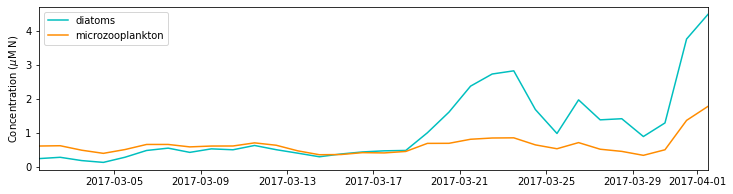

In [6]:
%%time
fig,ax=plt.subplots(1,1,figsize=(12,3))
ax.plot(tt,diat,'c-',label='diatoms')
ax.plot(tt,micZ,'-',color='darkorange',label='microzooplankton')
ax.legend(loc=2);
ax.set_ylabel('Concentration ($\mu$M N)')
ax.set_xlim(tt[0],tt[-1])

### repeat with hourly data over a shorter interval

In [7]:
start= dt.datetime(2017,3,1)
end=dt.datetime(2017,3,5) # the code called below (evaltools.index_model_files) includes the end date 
                          # in the values returned
tres=1 # 1: hourly resolution; 24: daily resolution   <- try changing to 1 and loading hourly data
flist=et.index_model_files(start,end,basedir,nam_fmt,flen,ftype,tres)
# flist contains paths: file pathes; t_0 timestemp of start of each file; t_n: timestamp of start of next file
flist

,paths,t_0,t_n
0,/results/SalishSea/nowcast-green.201812/01mar1...,2017-03-01,2017-03-02
1,/results/SalishSea/nowcast-green.201812/02mar1...,2017-03-02,2017-03-03
2,/results/SalishSea/nowcast-green.201812/03mar1...,2017-03-03,2017-03-04
3,/results/SalishSea/nowcast-green.201812/04mar1...,2017-03-04,2017-03-05
4,/results/SalishSea/nowcast-green.201812/05mar1...,2017-03-05,2017-03-06


In [8]:
# get model i,j of location S3 from places
ij,ii=places.PLACES['S3']['NEMO grid ji']
ik=0 # choose surface level

nlen= int(tres*24/flen) # number of data points per file

In [9]:
%%time
# create empty numpy arrays of shape of desired timeseries (1 dimension, length of flist)
tt= np.zeros((flist.shape[0]*nlen,),dtype=object) # array to hold times
micZ= np.zeros((flist.shape[0]*nlen,)) # array to hold microzo conc
diat= np.zeros((flist.shape[0]*nlen,)) # array to hold diatom conc
for ind, row in flist.iterrows():
    with nc.Dataset(row['paths']) as ff:
        tt[ind*nlen:(ind+1)*nlen]=[torig+dt.timedelta(seconds=xx) for xx in ff.variables['time_centered'][:]]
        micZ[ind*nlen:(ind+1)*nlen]=ff.variables['microzooplankton'][:,ik,ij,ii]
        diat[ind*nlen:(ind+1)*nlen]=ff.variables['diatoms'][:,ik,ij,ii]

CPU times: user 32.4 s, sys: 5.78 s, total: 38.1 s
Wall time: 40 s


CPU times: user 12 ms, sys: 4 ms, total: 16 ms
Wall time: 14 ms


(17226.020833333332, 17230.979166666668)

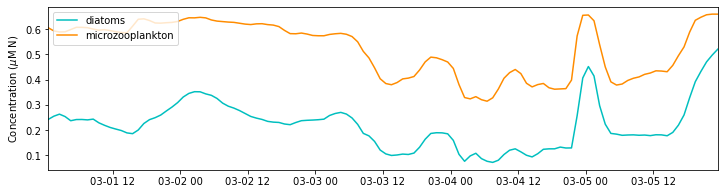

In [10]:
%%time
fig,ax=plt.subplots(1,1,figsize=(12,3))
ax.plot(tt,diat,'c-',label='diatoms')
ax.plot(tt,micZ,'-',color='darkorange',label='microzooplankton')
ax.legend(loc=2);
ax.set_ylabel('Concentration ($\mu$M N)')
ax.set_xlim(tt[0],tt[-1])